In [166]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import chart_studio.plotly as py
from urllib.request import urlopen
import plotly.express as px
import plotly
import json
import itertools
from matplotlib import pyplot as plt
import seaborn as sns

In [167]:
fips_to_pop = pd.read_csv("/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/misc_data/co-est2019-alldata.csv", encoding="latin-1")
fips_to_pop["fips"] = fips_to_pop.STATE.astype(str).str.zfill(2) + fips_to_pop.COUNTY.astype(str).str.zfill(3).replace("000", "")
fips_to_pop = fips_to_pop.set_index("fips")["CENSUS2010POP"].to_dict()

fips_to_dist = pd.read_csv("/project/biocomplexity/COVID-19_commons/2019-nCoV_spread-modeling/US_National/VA/PatchSim/data/VA_Gov_Regions.csv", dtype={"GEOID":str, "fips":str})
name_mapper = {s:s for s in fips_to_dist["VDH_Dist"].unique()}
name_mapper["Chikahominy"] = "Chickahominy"
name_mapper["Cumberland"] = "Cumberland Plateau"
name_mapper["Roanoke City"] = "Roanoke"
name_mapper["Pittsylvania Danville"] = "Pittsylvania-Danville"
for key in set(name_mapper.values()) - set(name_mapper.keys()):
    name_mapper[key] = key
fips_to_dist["VDH_Dist"] = fips_to_dist["VDH_Dist"].apply(lambda row: name_mapper[row])
fips_to_dist = dict(zip(fips_to_dist.GEOID.values, fips_to_dist.VDH_Dist.values))

dist_to_fips = {dist:[i for i,d in fips_to_dist.items() if d == dist] for dist in fips_to_dist.values()}
dist_to_pop = {dist:sum([fips_to_pop[i] for i in dist_to_fips[dist]]) for dist in dist_to_fips.keys()}

with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
    
counties["features"] = [i for i in counties["features"] if i["properties"]["STATE"] == "51"]

gisaid = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/variants/variant_samples_by_state.csv", parse_dates=["date"], dtype={"state":str})
gisaid_dates = gisaid.groupby("variant").date.min().to_dict()
va_gisaid = gisaid[gisaid.state == "51"]
va_gisaid_dates = va_gisaid.groupby("variant").date.min().to_dict()

In [223]:
state_samples = gisaid.groupby(["date", "state"]).count().rename(columns={"variant":"samples"})["samples"].reset_index().pivot(index="date", columns="state", values="samples").fillna(0)
# state_samples["51"].plot()

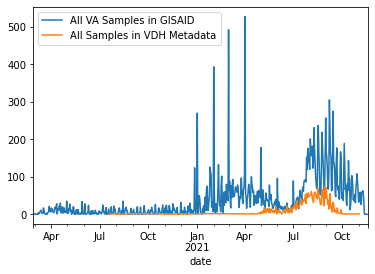

In [261]:
fig, ax = plt.subplots()
variants = pd.read_csv("/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/products/external_data_collection/VDH_opioids/VDH-UVA-DSA-COVID-19-Variant.tsv", sep="\t") #, parse_dates=["report_date", "date"], dtype={"fips":str})
# print(variants.columns)
variants = variants.iloc[:, [3, 6, 8, 11, 13, 14, 15, 21]]
variants.columns = ["variant", "age", "count", "district", "fips", "outbreak", "date", "seqid"]
variants.date = pd.to_datetime(variants.date)
variants.fips = variants.fips.astype(str)
variants = variants.sort_values("date")
variants = variants.dropna(subset=["date"])
state_samples["51"].plot(label="All VA Samples in GISAID")
variants.groupby("date").count().rename(columns={"variant":"samples"})["samples"].plot(ax=ax, label="All Samples in VDH Metadata")
ax.legend()
plt.savefig("total_VA_vs_DCLS_GISAID_samples.png", dpi=100, facecolor="white")
# fig, ax = plt.subplots()

start = "2021-10-09"
end = "2021-11-09"

cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/NyTimes/us-counties.csv", parse_dates=["date"], dtype={"fips":str}).dropna(subset=["fips"])
cases = cases[cases.state == "Virginia"].pivot(index="date", columns="fips", values="cases").fillna(0).diff().rolling(7).mean()
# ratios = (last_week_cases.T / last_week_cases.sum(axis=1)).T
# last_week_cases
ratios = (cases.T / cases.sum(axis=1)).T.iloc[-28:].median().to_dict()
# ratios

va_samples = variants.groupby(["date", "fips"]).count().rename(columns={"variant":"samples"})["samples"].reset_index().pivot(index="date", columns="fips", values="samples").fillna(0)
# ratios = va_samples.loc[start:end].sum()
# ratios = (ratios /ratios.sum()).to_dict()
scaled_samples = pd.DataFrame()
for fips in cases: #va_samples:
    scaled_samples[fips] = state_samples["51"].replace(0, np.nan).dropna() * ratios[fips]
# scaled_samples = scaled_samples.loc[start:end]
scaled_samples = scaled_samples.loc["2021-10-09":"2021-11-09"]
genomic_samples_per_day = scaled_samples.median().to_dict()

# state_samples["51"].loc[start:end].plot(label="All VA Samples in GISAID")
# variants.groupby("date").count().rename(columns={"variant":"samples"})["samples"].loc[start:end].plot(ax=ax, label="All Samples in VDH Metadata")

# ax.legend()

# plt.savefig("total_VA_vs_DCLS_GISAID_samples.png", dpi=100, facecolor="white")

In [262]:
genomic_detection_days = {fips:np.nan for fips in cases}
sgtf_detection_days = {fips:np.nan for fips in cases}

for fips in cases:
    cases_per_day = cases[fips].iloc[-7:].median()
#     print(fips, cases_per_day)
    if cases_per_day == 0:
        continue
    prevalence = 1 / cases_per_day
    sgtf_samples = cases_per_day * 0.7
    
    detection_df = pd.DataFrame([cases_per_day for i in range(300)], index=range(300), columns=["cases"])
    detection_df["prop"] = prevalence
    complement_sgtf = (1 - detection_df["prop"]) ** sgtf_samples
    detection_df["cum_prob_sgtf"] = 1 - complement_sgtf.cumprod()
    sgtf_days = detection_df[detection_df.cum_prob_sgtf >= 0.95].index.min()
    
    if fips in genomic_samples_per_day:
        complement_genomic = (1 - detection_df["prop"]) ** genomic_samples_per_day[fips]
        detection_df["cum_prob_genomic"] = 1 - complement_genomic.cumprod()
        genomic_days = detection_df[detection_df.cum_prob_genomic >= 0.95].index.min()
    else:
        genomic_days = np.nan
        
    genomic_detection_days[fips] = genomic_days
    sgtf_detection_days[fips] = sgtf_days
    
genomic_detection_days = pd.Series(genomic_detection_days).rename("Genomic")
sgtf_detection_days = pd.Series(sgtf_detection_days).rename("SGTF")

results = pd.concat([genomic_detection_days, sgtf_detection_days], axis=1)
results = results.melt(ignore_index=False).reset_index().rename(columns={"index":"fips", "variable":"Test Type"})

<AxesSubplot:>

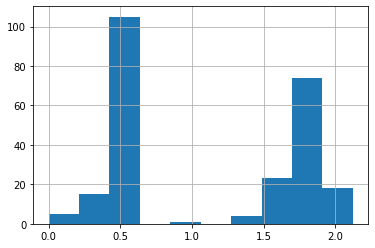

In [263]:
results.value.replace(0, 1).apply(lambda row: np.log10(row )).hist()

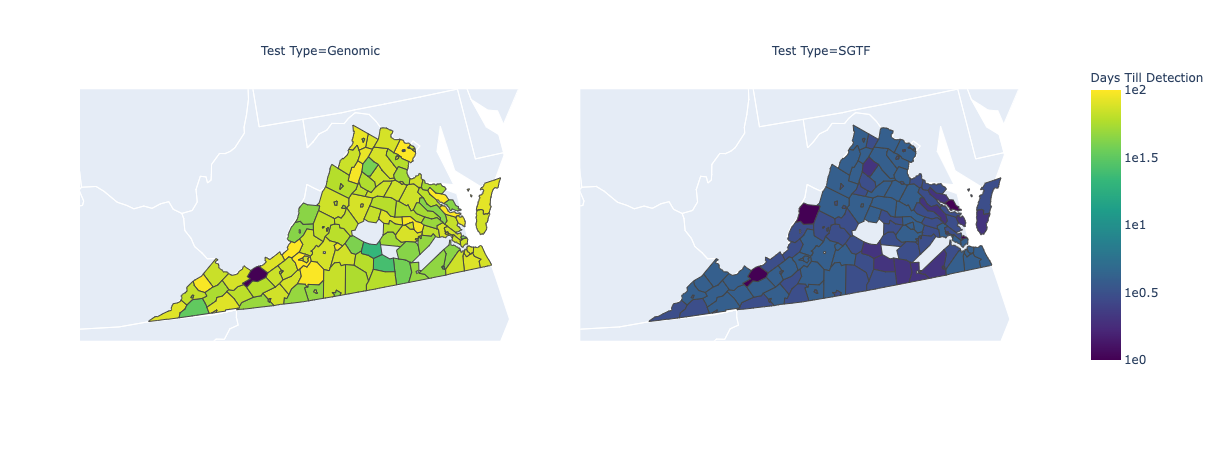

In [265]:
fig = px.choropleth(results, geojson=counties, locations='fips', color=np.log10(results['value'].replace(0, 1)), facet_col="Test Type",
#                             endpoints=endpts, colorscale=colorscale,
                           color_continuous_scale="Viridis",
                           range_color=(0, 2), #variant_datas.value.max()
                           scope="usa",
                           labels={'unemp':'unemployment rate'}
                          )

fig.update_geos(fitbounds="geojson", visible=True)
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}) #, 
#                   title={
#                     'text': f"{variant_name} in Virginia",
#                     'y':0.95,
#                     'x':0.5,
#                     'xanchor': 'center',
#                     'yanchor': 'top'})
# fig.update_layout(transition = {'duration': 1000})
# fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 400
fig.update_layout(coloraxis_colorbar=dict(title='Days Till Detection', tickprefix='1e'))
fig.show()
fig.write_html(f"virginia_detection_days_by_county.html")

### USA Analysis

In [266]:
state_to_stfips_path ="/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/misc_data/stfips_to_state.csv"
state_to_stfips_df = pd.read_csv(state_to_stfips_path, header=None, dtype={"2":str})
state_to_stfips_df[2] = state_to_stfips_df[2].astype(str).str.zfill(2)
state_to_stfips = state_to_stfips_df.set_index(0)[2].to_dict()
state_to_stfips = state_to_stfips_df.set_index(0)[2].to_dict()
state_to_state_abbr = state_to_stfips_df.set_index(0)[1].to_dict()
stfips_to_state_abbr = state_to_stfips_df.set_index(2)[1].to_dict()
abbr_to_stfips = state_to_stfips_df.set_index(1)[2].to_dict()

fips_to_pop = pd.read_csv("/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/misc_data/co-est2019-alldata.csv", encoding="latin-1")
fips_to_pop["fips"] = fips_to_pop.STATE.astype(str).str.zfill(2) + fips_to_pop.COUNTY.astype(str).str.zfill(3).replace("000", "")
fips_to_pop = fips_to_pop.set_index("fips")["CENSUS2010POP"].to_dict()

gisaid = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/variants/variant_samples_by_state.csv", parse_dates=["date"], dtype={"state":str})

cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/NyTimes/us-states.csv", parse_dates=["date"], dtype={"fips":str}).dropna(subset=["fips"])
cases = cases.pivot(index="date", columns="fips", values="cases").fillna(0).diff().rolling(7).mean()
# ratios = (cases.T / cases.sum(axis=1)).T.iloc[-28:].median().to_dict()


In [267]:
state_samples = gisaid.groupby(["date", "state"]).count().rename(columns={"variant":"samples"}).reset_index().pivot(index="date", columns="state", values="samples").fillna(0)
genomic_samples_per_day = state_samples.loc["2021-10-09":"2021-11-09"].median().to_dict()

In [269]:
genomic_detection_days = {fips:np.nan for fips in cases}
sgtf_detection_days = {fips:np.nan for fips in cases}

for fips in cases:
    cases_per_day = cases[fips].iloc[-7:].median()
#     print(fips, cases_per_day)
    if cases_per_day == 0:
        continue
    prevalence = 1 / cases_per_day
    sgtf_samples = cases_per_day * 0.7
    
#     print(fips, sgtf_samples)
    
    detection_df = pd.DataFrame([cases_per_day for i in range(300)], index=range(300), columns=["cases"])
    detection_df["prop"] = prevalence
    complement_sgtf = (1 - detection_df["prop"]) ** sgtf_samples
    detection_df["cum_prob_sgtf"] = 1 - complement_sgtf.cumprod()
#     print(detection_df.iloc[:10])
    sgtf_days = detection_df[detection_df.cum_prob_sgtf >= 0.95].index.min()
    
    if fips in genomic_samples_per_day:
        complement_genomic = (1 - detection_df["prop"]) ** genomic_samples_per_day[fips]
        detection_df["cum_prob_genomic"] = 1 - complement_genomic.cumprod()
        genomic_days = detection_df[detection_df.cum_prob_genomic >= 0.95].index.min()
    else:
        genomic_days = np.nan
        
    genomic_detection_days[fips] = genomic_days
    sgtf_detection_days[fips] = sgtf_days
    
genomic_detection_days = pd.Series(genomic_detection_days).rename("Genomic")
sgtf_detection_days = pd.Series(sgtf_detection_days).rename("SGTF")

results = pd.concat([genomic_detection_days, sgtf_detection_days], axis=1)
results = results.melt(ignore_index=False).reset_index().rename(columns={"index":"fips", "variable":"Test Type"})
results.fips = results.fips.apply(lambda row: stfips_to_state_abbr[row])

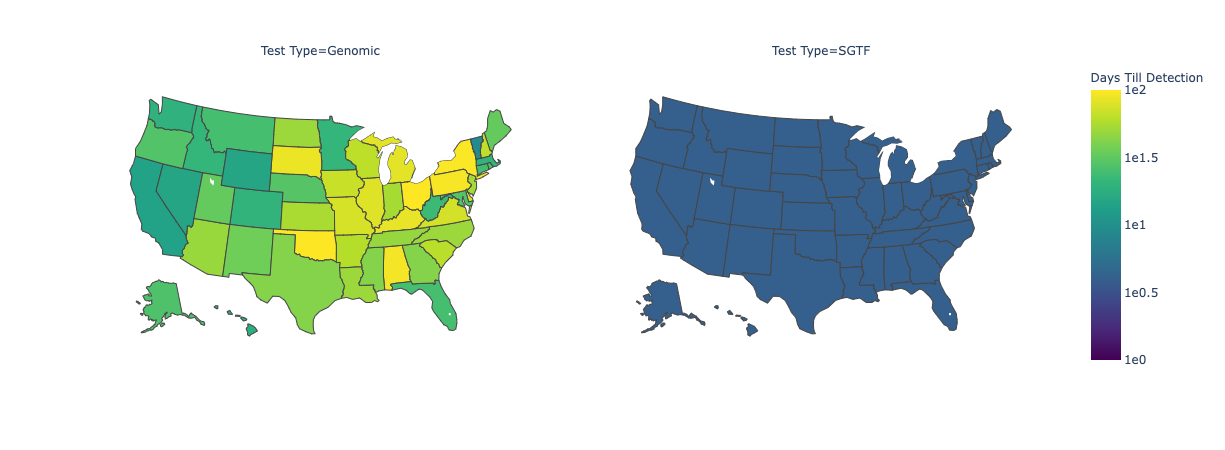

In [270]:
fig = px.choropleth(results, locations='fips', color=np.log10(results['value'].replace(0, 1)), facet_col="Test Type",
#                             endpoints=endpts, colorscale=colorscale,
                           color_continuous_scale="Viridis",
                           range_color=(0, 2), #variant_datas.value.max()
                           scope="usa",
                           locationmode = "USA-states",
                           labels={'unemp':'unemployment rate'}
                          )

# fig.update_geos(fitbounds="geojson", visible=True)
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}) #, 
#                   title={
#                     'text': f"{variant_name} in Virginia",
#                     'y':0.95,
#                     'x':0.5,
#                     'xanchor': 'center',
#                     'yanchor': 'top'})
# fig.update_layout(transition = {'duration': 1000})
# fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 400
fig.update_layout(coloraxis_colorbar=dict(title='Days Till Detection', tickprefix='1e'))
fig.show()
fig.write_html(f"usa_detection_days_by_state.html")

In [103]:
import requests
import json
import pandas as pd
from datetime import datetime
from pathlib import Path
import os, stat, sys

states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

headers = {"accept": "*/*", \
"user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36"}

# data = {"id": "integrated_county_timeseries_state_TX_external"}

dfs = []

for state in states:
    resp = requests.get(f"https://covid.cdc.gov/covid-data-tracker/COVIDData/getAjaxData?id=integrated_county_timeseries_state_{state}_external", headers=headers)
    if resp.status_code != 200:
        print(f"State {state} not found, status code: {resp.status_code}")
        break
        continue
    data = json.loads(resp.text)
    t = pd.DataFrame(data["integrated_county_timeseries_external_data"])
    for c in "date report_date_window_start report_date_window_end".split():
        t[c] = pd.to_datetime(t[c])
    t = t.rename(columns={"fips_code":"fips"})
    t.fips = t.fips.astype(str).str.zfill(5)
    t = t.sort_values("date")
    ordered_cs = ["date", "state", "state_name", "fips", "county"] 
    ordered_cs += list(set(t.columns) - set(ordered_cs))
    t = t[ordered_cs]
    dfs.append(t)
    break

State AL not found, status code: 500
